In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/porto_chosen_features.txt", 'w')

### Load the data

In [3]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [4]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [5]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [6]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)))

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [7]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [8]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [9]:
number_of_timesteps = 96

In [10]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 96/96 [00:02<00:00, 38.65it/s]


,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751995,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850,0.641933
1751996,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850
1751997,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,...,0.848700,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428
1751998,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,...,1.156395,0.848700,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781


In [ ]:
df_new.iloc[671,:]

In [42]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,DayOfWeek,Weekend,Hour
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,2,0,0
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2,0,0
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2,0,0
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2,0,0
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751995,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850,0.641933,2,0,22
1751996,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850,2,0,23
1751997,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,...,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,2,0,23
1751998,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,...,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,2,0,23


In [ ]:
df_new.to_csv("data/porto_last2hours.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [11]:
df_test = pd.read_csv("data/porto_best40features.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/porto_best40features.csv", engine='c', dtype=float32_cols)
df

,Time,Location,energy_lag_1,energy_lag_189,energy_lag_94,energy_lag_671,energy_lag_374,energy_lag_286,energy_lag_191,energy_lag_192,...,energy_lag_92,energy_lag_6,energy_lag_575,energy_lag_187,energy_lag_510,energy_lag_35,energy_lag_382,energy_lag_421,energy_lag_278,Energy
0,2019-01-08 00:00:00,1,1.362799,1.218622,0.517908,2.371797,2.192682,1.992285,1.430336,1.556923,...,0.254402,1.550280,0.372131,0.264859,1.379530,4.177094,4.270957,0.327352,2.245580,1.243963
1,2019-01-08 00:15:00,1,1.243963,0.792239,0.245668,2.415961,2.189238,2.743436,1.304366,1.430336,...,0.334733,1.758796,0.521968,0.262522,1.848600,3.261714,2.589786,0.240993,2.198833,1.289234
2,2019-01-08 00:30:00,1,1.289234,0.264859,0.254402,2.302538,2.211135,2.213350,1.218622,1.304366,...,0.227215,1.477207,0.407560,0.280113,2.213350,2.329233,2.268585,0.310991,2.200679,1.253928
3,2019-01-08 00:45:00,1,1.253928,0.262522,0.334733,2.363063,2.174599,2.281748,0.792239,1.218622,...,0.277653,1.251099,0.414080,0.266335,2.057239,1.959439,4.028980,0.304102,2.288268,1.233753
4,2019-01-08 01:00:00,1,1.233753,0.280113,0.227215,2.334031,2.145074,2.159590,0.264859,0.792239,...,0.368441,1.311378,0.413834,0.300288,1.650909,2.221223,2.137939,0.258462,2.217286,1.287758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.803087,0.935428,1.482914,1.026614,0.735802,0.931837,0.778195,...,1.077717,1.001887,0.716855,0.821869,0.294279,0.375228,0.935428,0.426166,1.285599,0.753222
1723196,2020-01-01 23:00:00,50,0.753222,0.600777,0.715781,1.772033,0.848700,0.485237,0.937079,0.931837,...,0.881889,0.467528,0.735802,0.997264,0.297623,0.321565,0.715781,0.190916,1.459798,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,0.821869,1.077717,2.535657,1.156395,0.394216,0.803087,0.937079,...,0.858855,0.483173,0.485237,1.210760,0.563833,0.414113,1.077717,0.105345,1.744294,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.997264,0.881889,2.055415,1.029379,0.429262,0.600777,0.803087,...,1.082588,0.481770,0.394216,1.707349,0.517930,0.297128,0.881889,0.091144,1.680559,0.485237


In [12]:
df = df[["Time", "Location", "energy_lag_1", "energy_lag_3", "energy_lag_95", "energy_lag_671", "Energy"]]
df

,Time,Location,energy_lag_1,energy_lag_3,energy_lag_95,energy_lag_671,Energy
0,2019-01-08 00:00:00,1,1.362799,1.251099,1.220344,2.371797,1.243963
1,2019-01-08 00:15:00,1,1.243963,1.311378,0.517908,2.415961,1.289234
2,2019-01-08 00:30:00,1,1.289234,1.362799,0.245668,2.302538,1.253928
3,2019-01-08 00:45:00,1,1.253928,1.243963,0.254402,2.363063,1.233753
4,2019-01-08 01:00:00,1,1.233753,1.289234,0.334733,2.334031,1.287758
...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.481770,0.752850,1.482914,0.753222
1723196,2020-01-01 23:00:00,50,0.753222,0.453906,0.935428,1.772033,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,1.099100,0.715781,2.535657,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.753222,1.077717,2.055415,0.485237


In [13]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([29, 12, 11, 42,  3, 28, 39, 32, 23,  5]),
 array([43, 30,  7, 20, 29, 18,  3, 44,  4, 22]),
 array([38, 24, 45, 43, 48, 21,  4, 31,  8,  7]),
 array([36, 38, 42, 27, 39, 44,  4, 34, 31, 37]),
 array([13, 15,  5,  9, 46,  2, 26, 25, 48, 24]),
 array([37, 47,  8, 42, 18, 15, 35, 34, 46, 40]),
 array([42, 21, 33, 44, 11, 30, 34, 26, 35, 20]),
 array([40, 27, 23, 32, 30, 44, 42, 18, 26, 24]),
 array([34, 30, 50, 39, 46,  1, 19,  5, 12,  3]),
 array([48,  8,  3, 10,  6, 27, 14, 38,  1, 20])]

In [40]:
df.iloc[95,:]

Time              2019-01-08 23:45:00
Location                            1
energy_lag_1                 0.304471
energy_lag_3                 0.324154
energy_lag_95                1.243963
energy_lag_671               0.345928
Energy                       0.259815
Name: 95, dtype: object

In [14]:
## Number of NaNs
df.isna().sum().sum()

0

In [15]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [16]:
df.Location.value_counts()

1     34464
38    34464
28    34464
29    34464
30    34464
31    34464
32    34464
33    34464
34    34464
35    34464
36    34464
37    34464
39    34464
2     34464
40    34464
41    34464
42    34464
43    34464
44    34464
45    34464
46    34464
47    34464
48    34464
49    34464
27    34464
26    34464
25    34464
24    34464
3     34464
4     34464
5     34464
6     34464
7     34464
8     34464
9     34464
10    34464
11    34464
12    34464
13    34464
14    34464
15    34464
16    34464
17    34464
18    34464
19    34464
20    34464
21    34464
22    34464
23    34464
50    34464
Name: Location, dtype: int64

### Linear Regression

In [17]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.3230
WAPE: 32.76
R2: 0.7463

Iteration 1
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1979
WAPE: 32.89
R2: 0.7715

Iteration 2
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1585
WAPE: 33.24
R2: 0.7272

Iteration 3
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1402
WAPE: 31.64
R2: 0.7610

Iteration 4
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.2320
WAPE: 32.03
R2: 0.7300


### XGBoost

In [18]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.3225
WAPE: 32.00
R2: 0.7466

Iteration 1
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1942
WAPE: 31.89
R2: 0.7757

Iteration 2
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1548
WAPE: 32.67
R2: 0.7335

Iteration 3
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1374
WAPE: 30.95
R2: 0.7658

Iteration 4
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.2201
WAPE: 30.64
R2: 0.7439


### Random Forest

In [19]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.3189
WAPE: 31.78
R2: 0.7495

Iteration 1
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1974
WAPE: 31.77
R2: 0.7720

Iteration 2
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1553
WAPE: 32.80
R2: 0.7327

Iteration 3
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1287
WAPE: 30.28
R2: 0.7806

Iteration 4
Train set:  (1378560, 7)
Test set:  (344640, 7)
MSE: 0.1970
WAPE: 29.58
R2: 0.7707


## Averaged Metrics

In [20]:
print("\n\n\n", file=sourceFile)

In [21]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.21
Total Averaged WAPE: 32.512
Total Averaged R2: 0.747


In [22]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.206
Total Averaged WAPE: 31.63
Total Averaged R2: 0.753


In [23]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.199
Total Averaged WAPE: 31.242
Total Averaged R2: 0.761


In [24]:
sourceFile.close()

### Feature Importance

In [33]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.94422
Feature: 1, Score: 0.01202
Feature: 2, Score: 0.02621
Feature: 3, Score: 0.01755


In [34]:
model_xgb.feature_importances_

array([0.9442234 , 0.01201948, 0.02620747, 0.01754966], dtype=float32)

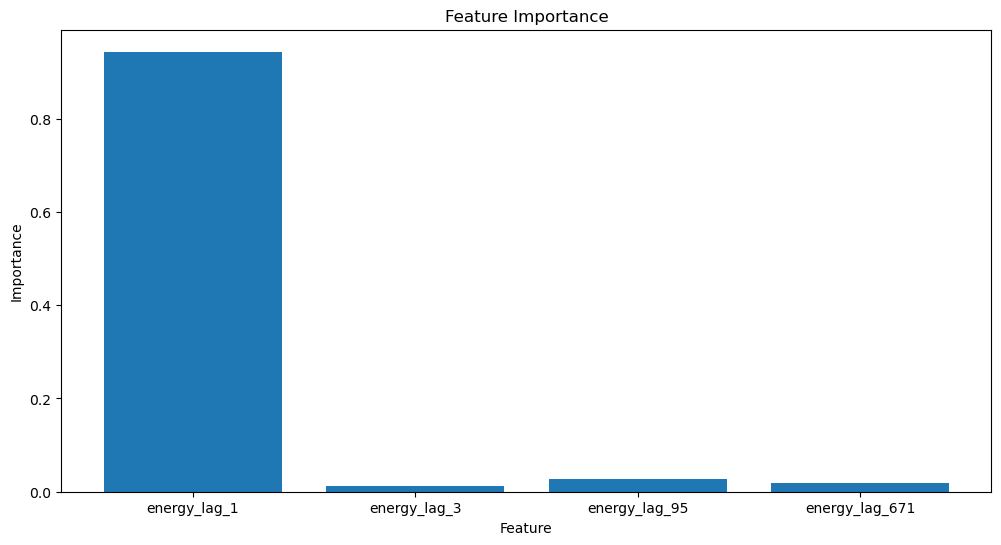

In [41]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("images/porto_xgb_last2hours_feature_importance.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[3:],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

### Test with 40 best features

In [ ]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

In [ ]:
df_test = pd.read_csv("data/porto_best40features.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_40 = pd.read_csv("data/porto_best40features.csv", engine='c', dtype=float32_cols)
df_40

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [ ]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [ ]:
sourceFile.close()